In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.utils.class_weight import compute_class_weight

from patchify import patchify

In [41]:
import segmentation_models as sm

from tensorflow.keras.utils import to_categorical

from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [3]:
data_dir = 'Semantic_segmentation_dataset/'
scaler = MinMaxScaler()
patch_size = 256

In [50]:
image_dataset = []  
for path, subdirs, files in os.walk(data_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):
                
                image = cv2.imread(path+"/"+image_name, 1) 
                
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))
                image = np.array(image)

                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        
                        image_dataset.append(single_patch_img)


In [51]:
mask_dataset = []  
for path, subdirs, files in os.walk(data_dir):
 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':  
        masks = os.listdir(path) 
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):
               
                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  
                mask = np.array(mask)             
       
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                            
                        mask_dataset.append(single_patch_mask) 
 

In [6]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [7]:
class_dict = pd.read_csv("class.csv", index_col=False, skipinitialspace=True)
class_dict

,name,color
0,Building,#3C1098
1,Land,#8429F6
2,Road,#6EC1E4
3,Vegetation,#FEDD3A
4,Water,#E2A929
5,Unlabeled,#9B9B9B


In [8]:
Building = np.array(tuple(int(class_dict['color'][0].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
Land = np.array(tuple(int(class_dict['color'][1].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
Road = np.array(tuple(int(class_dict['color'][2].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Vegetation = np.array(tuple(int(class_dict['color'][3].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Water = np.array(tuple(int(class_dict['color'][4].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Unlabeled = np.array(tuple(int(class_dict['color'][5].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))


In [9]:
label = single_patch_mask

In [10]:
def rgb_to_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)

    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]

    return label_seg

In [11]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [12]:
n_classes = len(np.unique(labels))

In [13]:
categorical_labels = to_categorical(labels, num_classes=n_classes)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, categorical_labels, test_size = 0.10, random_state = 42)

In [36]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [15]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [17]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [24]:
from unet_model import unet_model

model = unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [25]:
model = unet_model(n_classes, X_train.shape[1], X_train.shape[2], X_train.shape[3])
model.compile(optimizer='adam', loss=total_loss, metrics='accuracy')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 256, 256, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

In [37]:
history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    verbose = 1,
    validation_data=(X_test, y_test),
    shuffle = False
)

Epoch 1/100
37/37 [==============================] - 261s 7s/step - loss: 1.0047 - accuracy: 0.4813 - val_loss: 0.9889 - val_accuracy: 0.6523
Epoch 2/100
37/37 [==============================] - 259s 7s/step - loss: 0.9836 - accuracy: 0.6397 - val_loss: 0.9670 - val_accuracy: 0.6929
Epoch 3/100
37/37 [==============================] - 253s 7s/step - loss: 0.9635 - accuracy: 0.6767 - val_loss: 0.9535 - val_accuracy: 0.7520
Epoch 4/100
37/37 [==============================] - 245s 7s/step - loss: 0.9563 - accuracy: 0.7172 - val_loss: 0.9462 - val_accuracy: 0.7711
Epoch 5/100
37/37 [==============================] - 254s 7s/step - loss: 0.9497 - accuracy: 0.7378 - val_loss: 0.9472 - val_accuracy: 0.7494
Epoch 6/100
37/37 [==============================] - 260s 7s/step - loss: 0.9442 - accuracy: 0.7517 - val_loss: 0.9427 - val_accuracy: 0.7664
Epoch 7/100
37/37 [==============================] - 255s 7s/step - loss: 0.9412 - accuracy: 0.7621 - val_loss: 0.9414 - val_accuracy: 0.7708
Epoch 

In [38]:
model.save("model_100Epochs.h5")

In [40]:
model.save_weights("./")

In [45]:
new_model = load_model("model_100Epochs.h5", custom_objects={'dice_loss_plus_1focal_loss' : total_loss})

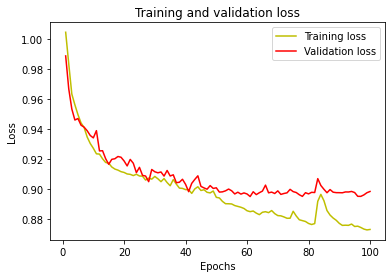

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
y_pred=new_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

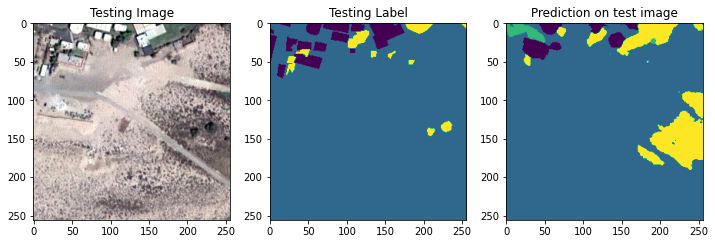

In [85]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()